# 🎓 **Taller 4.6.2: Taller de Métodos de Clustering Basados en Densidad**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a ver cómo funcionan los algoritmos de clustering basado en Densidad los cuales agrupan puntos de datos basándose en regiones de alta densidad de puntos, separadas por regiones de baja densidad.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

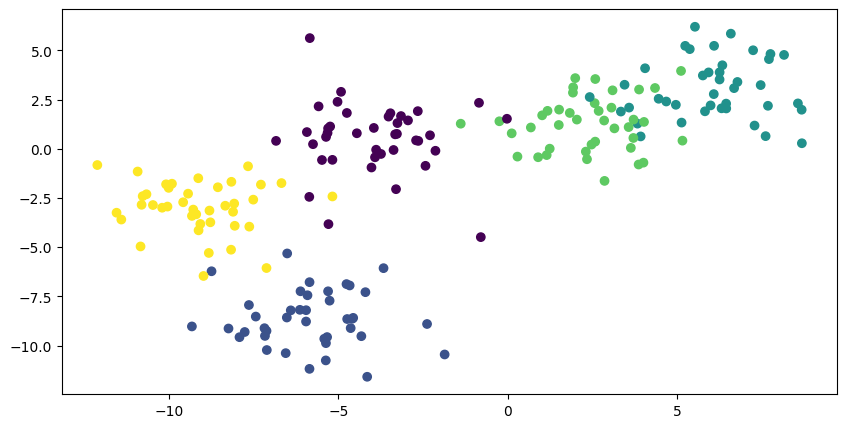

In [3]:
from sklearn.datasets import make_blobs

np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

Dx, Dy = make_blobs(200, 2, centers=5, cluster_std=1.5)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)

# 🎯 **1:Cree el Algoritmo de Clustering Mean Shift**

## Calcular el Kernel Gausiano


In [4]:
def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

El algoritmo MeanShift usa la función kernel para delimitar el vecindario y devolver el peso de cada instancia del vecindario

In [8]:
def kernel_gaussiano(mDistancia, i, h):
    dist = mDistancia[i, :]
    # Kernel gaussiano
    weights = np.exp(-(dist**2) / (2 * h**2))
    # Solo se aceptan los que estén en el vecindario (bandwidth efectivo)
    weights[weights <= (1.0 / np.e)] = 0
    return weights

Complete la función que calcula el vector shift y el centro de masa ponderado

In [9]:
def mean_shift_vector(X, weights, i):
    # Asegurar que weights tenga la forma correcta
    weights = weights.reshape(-1, 1)
    # Calcular centro de masa ponderado
    numerador = np.sum(X * weights, axis=0) # p2. Complete el codigo
    denominador = np.sum(weights) # p3. Complete el codigo
    if denominador > 0:
        centro_masa_ponderado = numerador / denominador
        shift = centro_masa_ponderado - X[i, :]
        return centro_masa_ponderado, shift
    else:
        return X[i, :], np.zeros_like(X[i, :])

Ahora cree el algoritmo mean shift iterativo

In [11]:
from sklearn.metrics.pairwise import euclidean_distances

def agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=100, tolerancia=1e-5):
    actDx = np.copy(Dx)
    n_muestras = actDx.shape[0]

    # Historial de trayectorias para graficar (opcional)
    trayectorias = np.zeros((n_iteraciones, n_muestras, actDx.shape[1]))

    for iteracion in range(n_iteraciones):
        actDx_anterior = np.copy(actDx)
        mDistancia = matriz_distancias(actDx, distancia_euclidiana)
        for i in range(n_muestras):
            # Calcular pesos usando kernel gaussiano
            weights = kernel_gaussiano(mDistancia, i, h) # p4. Complete el codigo
            # Calcular nuevo centro de masa
            nuevo_punto, shift = mean_shift_vector(actDx, weights, i) # p5. Complete el codigo
            actDx[i, :] = nuevo_punto
        # Guardar trayectoria (opcional)
        trayectorias[iteracion, :, :] = actDx
        # Verificar convergencia
        desplazamiento_total = np.sum(np.linalg.norm(actDx - actDx_anterior, axis=1)) # p6. Complete el codigo
        if iteracion % 3 == 0:
            print(f"Iteración {iteracion}: Desplazamiento medio = {desplazamiento_total:.6f}")

        if desplazamiento_total < tolerancia:
            print(f"Convergencia alcanzada en iteración {iteracion}")
            trayectorias = trayectorias[:iteracion+1, :, :]
            break

    centros = np.unique(np.round(actDx ,3), axis=0)
    # Asignar cada punto al centroide más cercano
    asignacion = np.argmin(euclidean_distances(Dx, centros), axis=1) # p7. Complete el codigo
    return np.array(centros), asignacion, trayectorias[:iteracion+1, :, :]

Esta función permite vizuaizar la asignacion de los puntos a los clusters y la trayectoria de algunos puntos desde su posicion inicial al centro del cluster

In [12]:
def visualizar_proceso_mean_shift(X, h, centroides, etiquetas, trayectorias=None):
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Gráfico 1: Datos originales y clusters finales
        axes[0].scatter(X[:, 0], X[:, 1], c=etiquetas, cmap='viridis', alpha=0.6, s=50)
        axes[0].scatter(centroides[:, 0], centroides[:, 1], c='red', marker='X', s=100, label='Centroides')
        axes[0].set_title(f'Resultado Mean Shift (h={h})')
        axes[0].set_xlabel('Feature 1')
        axes[0].set_ylabel('Feature 2')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Gráfico 2: Trayectorias de los puntos (si está disponible)
        if trayectorias is not None and trayectorias.shape[0] > 1:
            for i in range(min(50, X.shape[0])):  # Mostrar solo algunos puntos
                axes[1].plot(trayectorias[:, i, 0], trayectorias[:, i, 1],
                           alpha=0.5, linewidth=1)
            axes[1].scatter(X[:, 0], X[:, 1], c='gray', alpha=0.3, s=30, label='Inicio')
            axes[1].scatter(centroides[:, 0], centroides[:, 1], c='red',
                          marker='X', s=200, label='Final')
            axes[1].set_title('Trayectorias de convergencia')
            axes[1].set_xlabel('Feature 1')
            axes[1].set_ylabel('Feature 2')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib no está instalado. Instala con: pip install matplotlib")


## Ahora ya estamos en disposición de realizar el Mean Shift.


In [13]:
 # Aplicar Mean Shift
h = 4.0  # Bandwidth
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50)

print(f"\nNúmero de clusters encontrados: {len(centroides)}")
print(f"Centroides: {centroides}")


Iteración 0: Desplazamiento medio = 296.610418
Iteración 3: Desplazamiento medio = 115.162921
Iteración 6: Desplazamiento medio = 0.151680
Iteración 9: Desplazamiento medio = 0.000320
Convergencia alcanzada en iteración 11

Número de clusters encontrados: 2
Centroides: [[-5.765 -3.711]
 [ 2.708  1.706]]


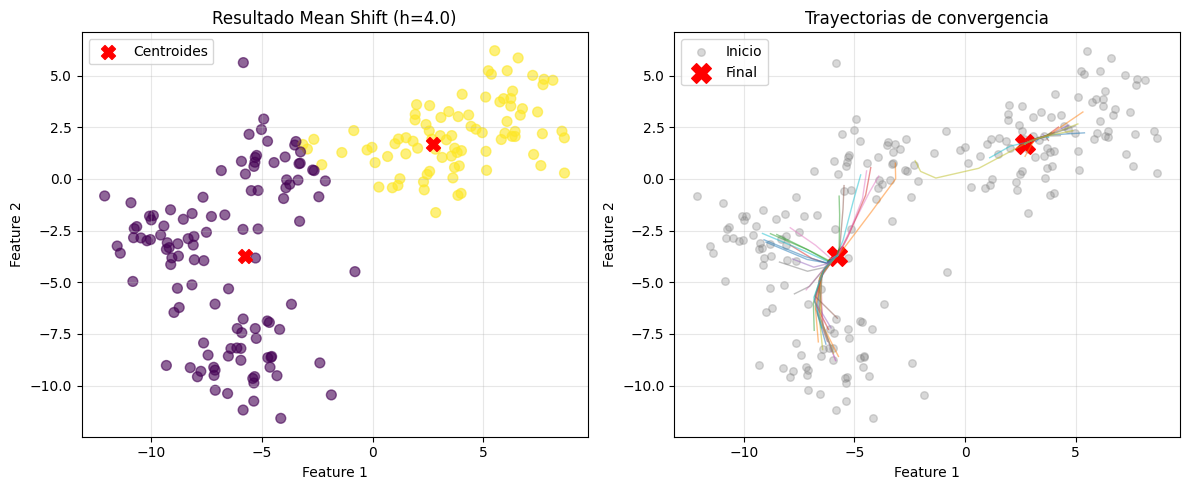

In [14]:
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

<hr>
Podemos jugar con diferentes valores de $\epsilon$ y $M$ para ver su efecto sobre diferentes conjuntos de datos:


In [15]:
D =cargar_dataset("dataset_dos_remolinos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


Iteración 0: Desplazamiento medio = 1.024057
Iteración 3: Desplazamiento medio = 0.331747
Iteración 6: Desplazamiento medio = 0.092793
Iteración 9: Desplazamiento medio = 0.007132
Iteración 12: Desplazamiento medio = 0.000075
Convergencia alcanzada en iteración 14

Número de clusters encontrados: 493


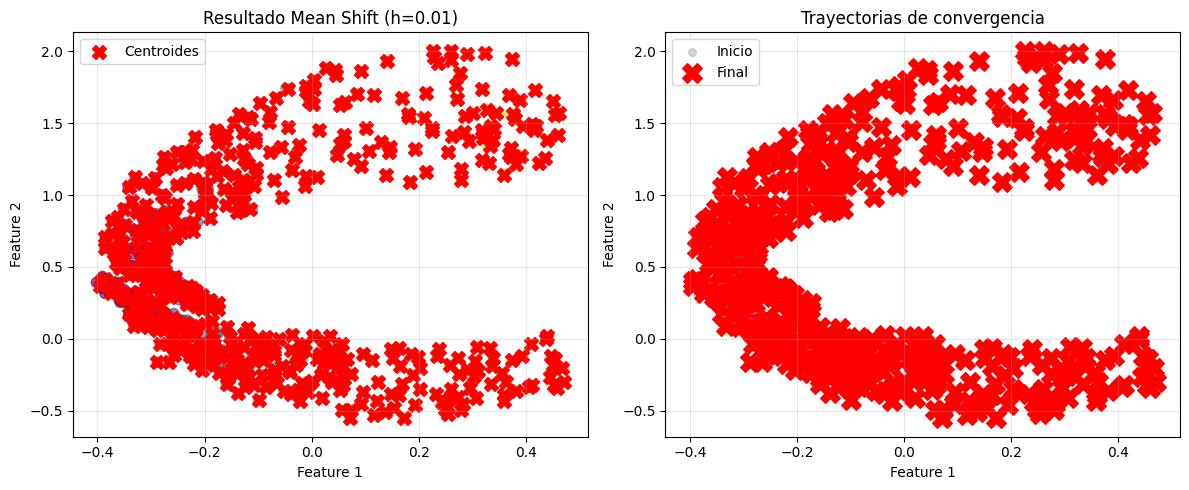

In [17]:
 # Aplicar Mean Shift
h = 0.01
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50) # p8. Complete el codigo
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

Iteración 0: Desplazamiento medio = 53.416181
Iteración 3: Desplazamiento medio = 37.971161
Iteración 6: Desplazamiento medio = 1.243991
Iteración 9: Desplazamiento medio = 0.004078
Iteración 12: Desplazamiento medio = 0.000007
Convergencia alcanzada en iteración 12

Número de clusters encontrados: 4


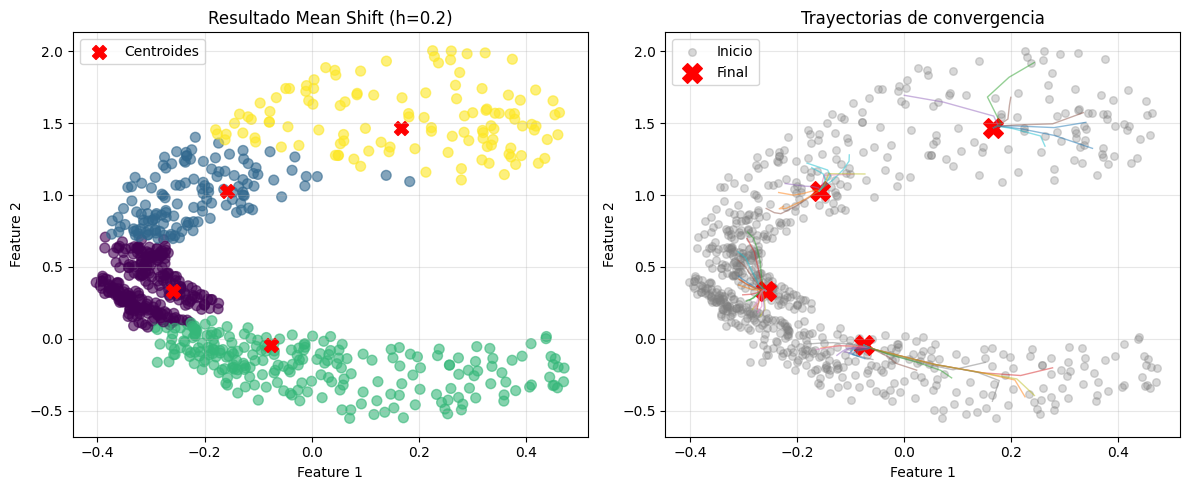

In [19]:
# Aplicar Mean Shift
h = 0.2
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

Iteración 0: Desplazamiento medio = 154.028072
Iteración 3: Desplazamiento medio = 82.943524
Iteración 6: Desplazamiento medio = 0.027722
Iteración 9: Desplazamiento medio = 0.000048
Convergencia alcanzada en iteración 10

Número de clusters encontrados: 1


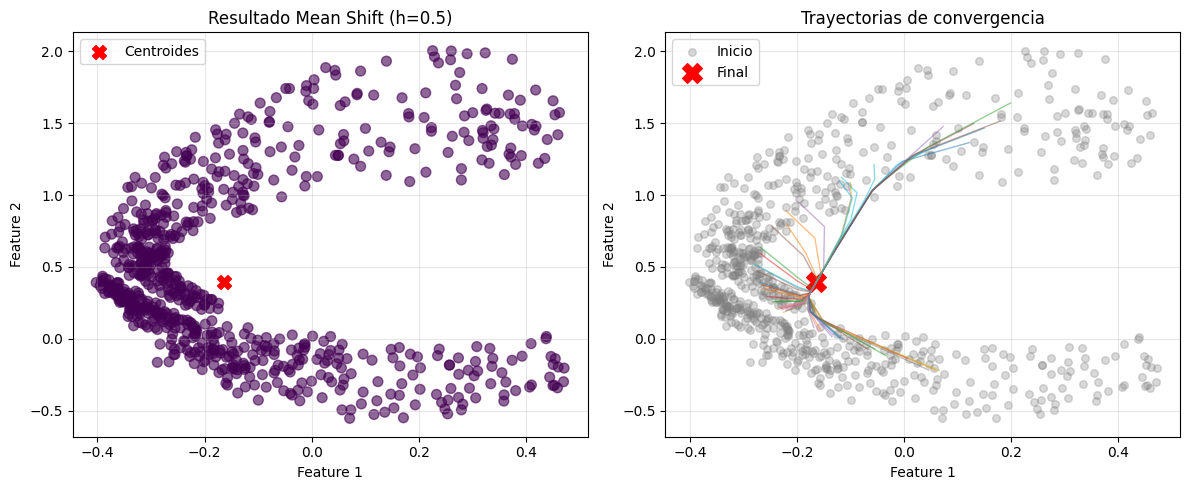

In [20]:
 # Aplicar Mean Shift
h = 0.5
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

## Definir el rango de experimentación de h

Complete el calculo de los metodos para definir h

In [22]:
def calcular_h_automatico(X, metodo='silverman', dimension=None):
    n_muestras, n_caracteristicas = X.shape
    if metodo == 'silverman':
        # Regla de Silverman para múltiples dimensiones
        # h = σ * n^{-1/(d+4)}
        if dimension is None:
            # Usar promedio de desviaciones estándar
            sigma = np.mean(np.std(X, axis=0))
        else:
            sigma = np.std(X[:, dimension])
        h = sigma * (n_muestras ** (-1 / (n_caracteristicas + 4))) # p11. Complete el codigo
        info = {
            'metodo': 'Regla de Silverman',
            'sigma': sigma,
            'n_muestras': n_muestras,
            'n_caracteristicas': n_caracteristicas,
            'formula': 'h = σ * n^{-1/(d+4)}'
        }
    elif metodo == 'scott':
        # Regla de Scott: h = σ * n^{-1/(d+4)}
        # Similar a Silverman pero con factor diferente
        if dimension is None:
            sigma = np.mean(np.std(X, axis=0))
        else:
            sigma = np.std(X[:, dimension])
        # Factor de Scott: 1.06
        factor = 1.06
        h = factor * sigma * (n_muestras ** (-1 / (n_caracteristicas + 4))) # p12. Complete el codigo
        info = {
            'metodo': 'Regla de Scott',
            'sigma': sigma,
            'factor': factor,
            'n_muestras': n_muestras,
            'n_caracteristicas': n_caracteristicas
        }

    elif metodo == 'rango':
        # Porcentaje del rango total de datos
        rangos = np.ptp(X, axis=0)  # peak-to-peak (máx - mín)
        rango_promedio = np.mean(rangos)
        # Usar 15% del rango como punto de partida
        porcentaje = 0.15
        h = porcentaje * rango_promedio # p13. Complete el codigo

        info = {
            'metodo': 'Porcentaje del rango',
            'rango_promedio': rango_promedio,
            'porcentaje': porcentaje,
            'rangos_individuales': rangos.tolist()
        }

    elif metodo == 'std':
        # Fracción de la desviación estándar
        stds = np.std(X, axis=0)
        std_promedio = np.mean(stds)

        # Usar 1/3 de la desviación estándar
        fraccion = 0.33
        h = fraccion * std_promedio # p14. Complete el codigo

        info = {
            'metodo': 'Fracción de desviación estándar',
            'std_promedio': std_promedio,
            'fraccion': fraccion,
            'stds_individuales': stds.tolist()
        }

    else:
        raise ValueError(f"Método '{metodo}' no reconocido. Usar: 'silverman', 'scott', 'rango', 'std'")
    return h, info

Experimente con el dataset

In [23]:
D =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


In [24]:
# Métodos a evaluar
metodos = ['silverman', 'scott', 'rango', 'std']

print("\n" + "="*70)
print("CÁLCULO DE BANDWIDTH (h) CON DIFERENTES MÉTODOS")
print("="*70)
# Calcular h para cada método
for metodo in metodos:
    h_base, info = calcular_h_automatico(Dx, metodo)
    print(f"\nMétodo: {metodo.upper()}")
    print(f"  h calculado: {h_base:.6f}")

    # Información adicional específica por método
    if 'sigma' in info:
        print(f"  Sigma usado: {info['sigma']:.6f}")
    if 'rango_promedio' in info:
        print(f"  Rango promedio: {info['rango_promedio']:.6f}")
    if 'std_promedio' in info:
        print(f"  Std promedio: {info['std_promedio']:.6f}")



CÁLCULO DE BANDWIDTH (h) CON DIFERENTES MÉTODOS

Método: SILVERMAN
  h calculado: 0.069085
  Sigma usado: 0.245201

Método: SCOTT
  h calculado: 0.073231
  Sigma usado: 0.245201

Método: RANGO
  h calculado: 0.147554
  Rango promedio: 0.983692

Método: STD
  h calculado: 0.080916
  Std promedio: 0.245201


Experimentar con los valores de h, desde el valor minimo al maximo, incrementando de poco a poco y graficando los resultados del agrupamiento.


EXPERIMENTANDO CON DIFERENTES VALORES DE BANDWIDTH (h)

--- Ejecutando Mean Shift con h = 0.0484 ---
Iteración 0: Desplazamiento medio = 29.209496
Iteración 3: Desplazamiento medio = 29.457896
Iteración 6: Desplazamiento medio = 10.510295
Iteración 9: Desplazamiento medio = 0.424169
Iteración 12: Desplazamiento medio = 0.958262
Iteración 15: Desplazamiento medio = 0.000112
Convergencia alcanzada en iteración 17
Número de clusters encontrados: 16


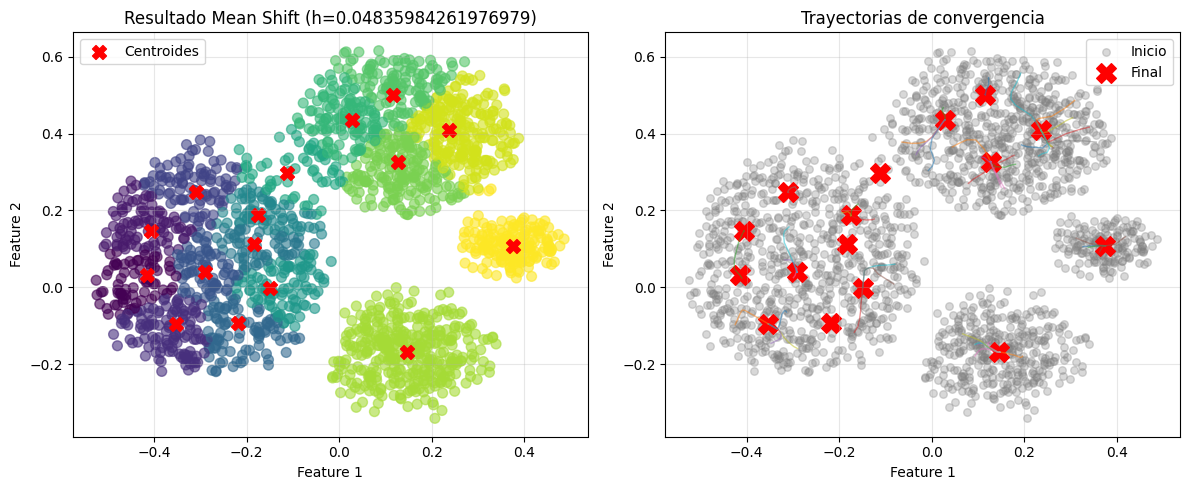


--- Ejecutando Mean Shift con h = 0.0842 ---
Iteración 0: Desplazamiento medio = 65.223997
Iteración 3: Desplazamiento medio = 42.667067
Iteración 6: Desplazamiento medio = 14.791389
Iteración 9: Desplazamiento medio = 0.001674
Iteración 12: Desplazamiento medio = 0.000003
Convergencia alcanzada en iteración 12
Número de clusters encontrados: 4


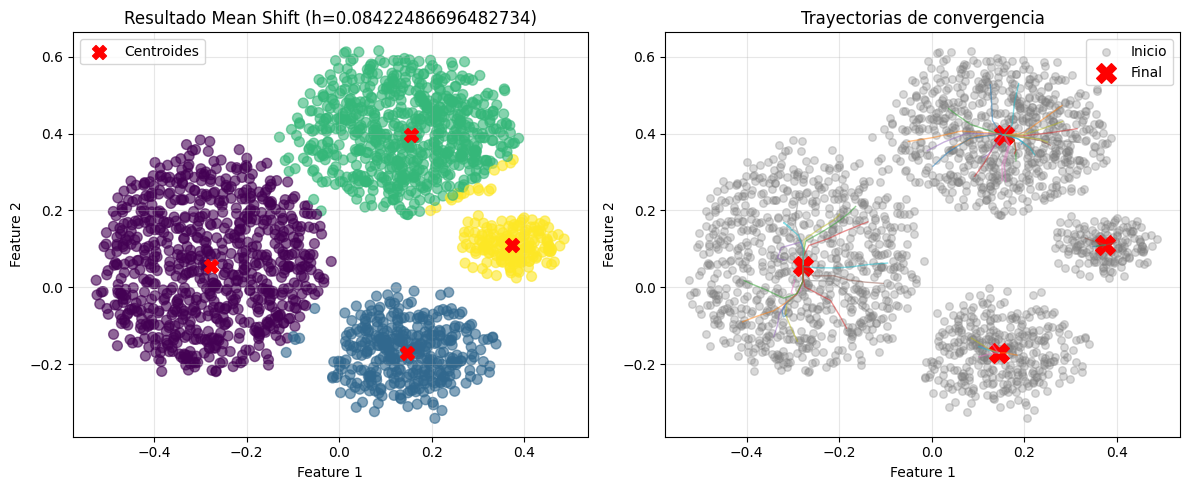


--- Ejecutando Mean Shift con h = 0.1201 ---
Iteración 0: Desplazamiento medio = 102.056077
Iteración 3: Desplazamiento medio = 14.958811
Iteración 6: Desplazamiento medio = 0.001935
Iteración 9: Desplazamiento medio = 0.000004
Convergencia alcanzada en iteración 9
Número de clusters encontrados: 4


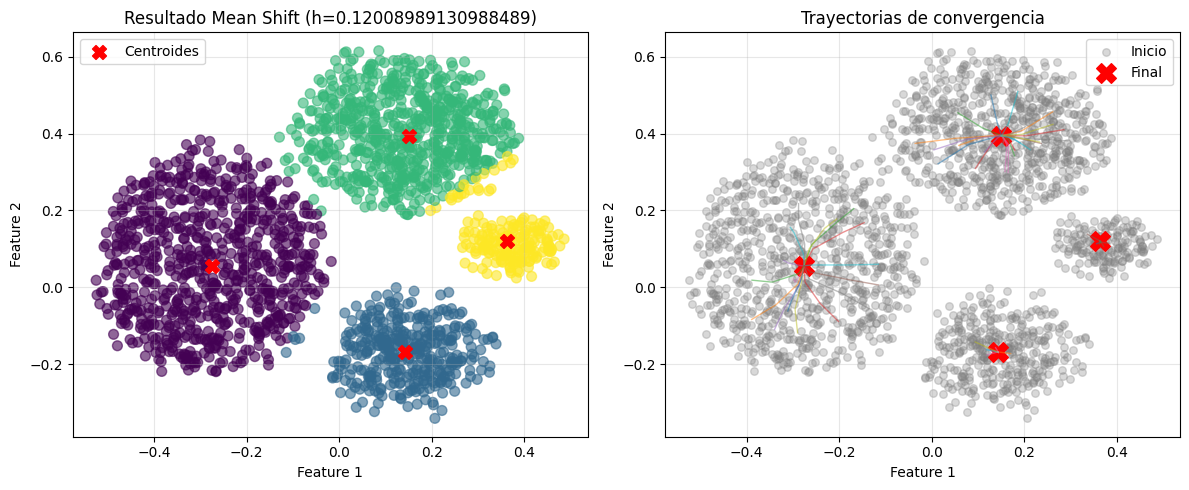


--- Ejecutando Mean Shift con h = 0.1560 ---
Iteración 0: Desplazamiento medio = 132.726766
Iteración 3: Desplazamiento medio = 5.746901
Iteración 6: Desplazamiento medio = 9.078858
Iteración 9: Desplazamiento medio = 0.248437
Iteración 12: Desplazamiento medio = 0.000446
Convergencia alcanzada en iteración 14
Número de clusters encontrados: 3


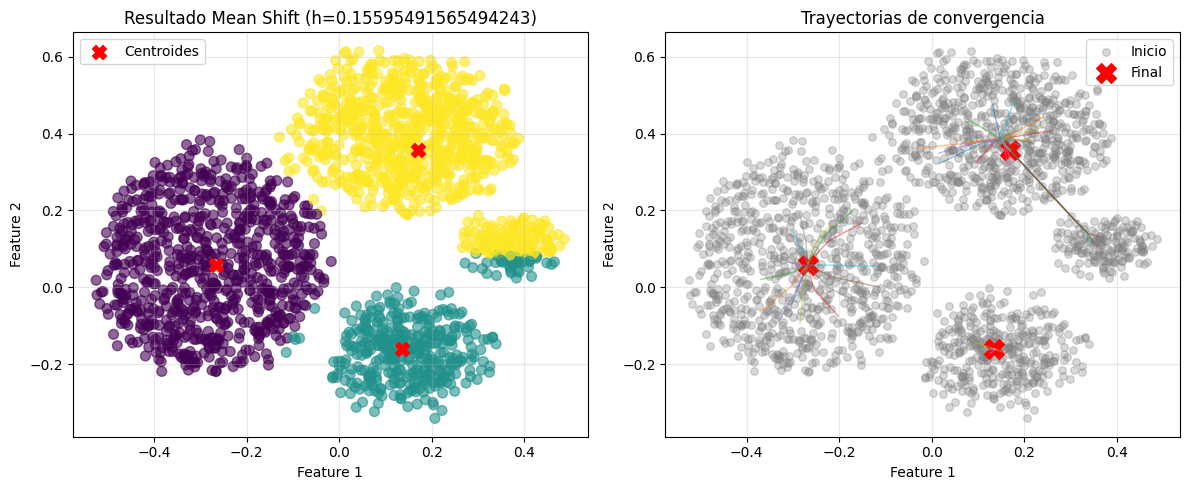


--- Ejecutando Mean Shift con h = 0.1918 ---
Iteración 0: Desplazamiento medio = 158.381160


In [ ]:
# p15. Complete el codigo

# Obtener los valores calculados de h para establecer un rango
h_silverman, _ = calcular_h_automatico(Dx, 'silverman')
h_scott, _ = calcular_h_automatico(Dx, 'scott')
h_rango, _ = calcular_h_automatico(Dx, 'rango')
h_std, _ = calcular_h_automatico(Dx, 'std')

min_h = min(h_silverman, h_scott, h_rango, h_std) * 0.7 # Un poco por debajo del mínimo
max_h = max(h_silverman, h_scott, h_rango, h_std) * 1.3 # Un poco por encima del máximo

h_values = np.linspace(min_h, max_h, 5) # Probar 5 valores equiespaciados en el rango

print("\n" + "="*70)
print("EXPERIMENTANDO CON DIFERENTES VALORES DE BANDWIDTH (h)")
print("="*70)

for h_val in h_values:
    print(f"\n--- Ejecutando Mean Shift con h = {h_val:.4f} ---")
    centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h_val, n_iteraciones=50)
    print(f"Número de clusters encontrados: {len(centroides)}")
    visualizar_proceso_mean_shift(Dx, h_val, centroides, etiquetas, trayectorias)

<hr>
<h2>Implementaciones en librerías de Python</h2>

Scikit-learn (scikit-learn) es la implementación más popular y ampliamente utilizada:

In [ ]:
from sklearn.cluster import MeanShift

# Uso básico
ms = MeanShift(bandwidth=0.5)
ms.fit(Dx)

# Obtener resultados
etiquetas = ms.labels_
centros = ms.cluster_centers_

In [ ]:
 # GRAFICAR LOS GRUPOS

 # P16 SU CODIGO AQUI
plt.figure(figsize=(10, 7))
plt.scatter(Dx[:, 0], Dx[:, 1], c=etiquetas, cmap='viridis', alpha=0.6, s=50)
plt.scatter(centros[:, 0], centros[:, 1], c='red', marker='X', s=150, label='Centroides SKLearn')
plt.title(f'Mean Shift Clustering con Scikit-learn (bandwidth={ms.bandwidth})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 🚀 ¡TALLER FINALIZADO!"